In [46]:
from scipy.special import hermite
from scipy.integrate import quad
from numpy import pi, sqrt, exp, conj, real, imag, sin, cos
from math import factorial
import numpy as np
import matplotlib.pyplot as plt

Полиномы Эрмита
$$
    H_n(x)= e^{x^2/2} \left(\frac{d}{dx} - x\right)^n e^{-x^2/2}
$$
Функции Эрмита
$$
    \mathcal H_n(x) = \frac{1}{\pi^{1/4} 2^{n/2} \sqrt{n!}} H_n(x) \, e^{-x^2/2}
$$
Нормировка функций Эрмита
$$
    (\mathcal H_n, \mathcal H_m) = \int_{-\infty}^{\infty} dx \, \mathcal H_n(x)\, \mathcal H_m(x) = \delta_{nm}
$$

In [2]:
def herm_n(k):
    '''Возвращает нормированный полином Эрмита.
    '''
    return hermite(k) / (2**(k/2) * pi**(1/4) * sqrt(factorial(k)))

def herm_f(k, x):
    '''Возвращает нормированную функцию Эрмита.
    '''
    return herm_n(k)(x) * exp(-x**2 / 2)

По функциям Эрмита можно разложить произвольную функцию $f(x)$, достаточно быстро затухающую на бесконечности
$$
    f_n = (\mathcal H_n, f) = \int_{-\infty}^{\infty} dx \, \mathcal H_n(x)\, f(x)
$$
$$
    f(x) = \sum_{n=0}^\infty f_n \, \mathcal H_n(x)
$$

In [13]:
def proj(k, f):
    '''Возвращает проекцию функции f на k-ую функцию Эрмита
    '''
    return quad(lambda x: herm_f(k, x) * f(x), -100, 100)[0]

Уравнение Шрёдингера для осциллятора
$$
    i \hbar \partial_t \psi(t, x) = \left(-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + \frac{m \omega x^2}{2}\right) \psi(t, x)
$$
Если время и координаты выразить в единицах
$$
    x_0 = \sqrt{\frac{\hbar}{m\omega}}, \qquad t_0 = \frac{2\pi}{\omega},
$$
оно примет вид
$$
    i \partial_t \psi(t, x) = \pi \left(-\frac{\partial^2}{\partial x^2} + x^2\right) \psi(t, x).
$$
Решениями стационарного уравнения Шрёдингера
$$
    \pi \left(-\frac{\partial^2}{\partial x^2} + x^2\right) \psi(x) = E \, \psi(x).
$$
являются функции Эрмита
$$
    \pi \left(-\frac{\partial^2}{\partial x^2} + x^2\right) \mathcal H_n(x) = E_n \, \mathcal H_n(x), \quad E_n = 2\pi \, (n + \tfrac12).
$$
Тогда $\mathcal H_n(x) \, e^{-iE_n t}$ решают нестационарное уравнение Шрёдингера, и проивольное решение имеет вид
$$
    \psi(t, x) = \sum_{n=0}^\infty \psi_n \, \mathcal H_n(x) \, e^{-2\pi i (n + \frac12)t},
$$
где $\psi_n$ определяются начальным профилем волновой функции $\psi(x)$ в момент $t=0$
$$
    \psi_n = (\mathcal H_n, \psi) = \int_{-\infty}^{\infty} dx \, \mathcal H_n(x)\, \psi(x)
$$

Взятие производной и умножение функции Эрмита на $x$ снова выражается через функции Эрмита
\begin{align}
    \frac{d}{dx} \mathcal H_n(x) &= \sqrt{\frac{n}{2}} \mathcal H_{n-1}(x) - \sqrt{\frac{n+1}{2}} \mathcal H_{n+1}(x)\\
    x \mathcal H_n(x) &= \sqrt{\frac{n}{2}} \mathcal H_{n-1}(x) + \sqrt{\frac{n+1}{2}} \mathcal H_{n+1}(x)
\end{align}

In [57]:
class Oscillator():
    def __init__(self, in_cond, N=10):
        norm = sqrt(quad(lambda x: abs(in_cond(x))**2, -100, 100)[0])
        self.in_cond = lambda x: in_cond(x) / norm
        
        self.N = N
        
        self.coefs = []
        for k in range(N):
            self.coefs.append(proj(k, self.in_cond))
    
    def ampl(self, t):
        return lambda x: sum([self.coefs[k] * herm_f(k, x) * exp(-2.j*pi*(k + 0.5)*t) 
                              for k in range(self.N)])
    
    def prob(self, t):
        return lambda x: abs(self.ampl(t)(x))**2
    
    def momentum(self, t):
        coefs = np.array(self.coefs)
        m = np.array(range(0, self.N - 1))
        return (sqrt(2*(m + 1)) * imag(coefs[1:] * conj(coefs[:-1])) * cos(2*pi*t) - 
                sqrt(2*(m + 1)) * real(coefs[1:] * conj(coefs[:-1])) * sin(2*pi*t)).sum()
    
    def coord(self, t):
        coefs = np.array(self.coefs)
        m = np.array(range(0, self.N - 1))
        return (sqrt(2*(m + 1)) * real(coefs[1:] * conj(coefs[:-1])) * cos(2*pi*t) + 
                sqrt(2*(m + 1)) * imag(coefs[1:] * conj(coefs[:-1])) * sin(2*pi*t)).sum()

In [58]:
osc = Oscillator(lambda x: exp(-abs((x-1))), N=20)

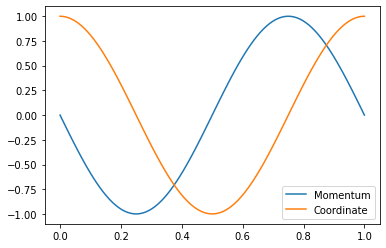

In [59]:
l_t = np.linspace(0, 1, 100)
plt.plot(l_t, [osc.momentum(t) for t in l_t], label="Momentum")
plt.plot(l_t, [osc.coord(t) for t in l_t], label="Coordinate")
plt.legend()
plt.show()

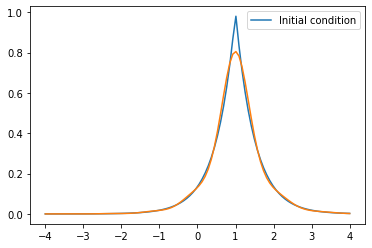

In [31]:
l = np.linspace(-4, 4, 100)
plt.plot(l, [osc.in_cond(x)**2 for x in l], label="Initial condition")
plt.plot(l, [osc.prob(1)(x) for x in l])
plt.legend()
plt.show()

Задание:
1. Найти волновую функцию локализованной частицы с ненулевым начальным импульсом.
2. Найти срекнеквадратичное отклонение координаты и импульса относительно среднего значения в зависимости от времени.
3. Найти зависимость этих среднеквадратичных отклонений от степени локализованности (характерной ширины графика волновой функции в начальный момент)